In [1]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = r"NeoJaundice\chd_jaundice_published_2.csv"
IMG_DIR = r"NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_mask_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def extract_yellow_card_mask(img):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    return extract_mask_hsv(img, lower_yellow, upper_yellow)

def extract_white_card_mask(img):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    return extract_mask_hsv(img, lower_white, upper_white)

def extract_black_card_mask(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    return extract_mask_hsv(img, lower_black, upper_black)

def extract_red_card_mask(img):
    lower_red1 = np.array([0, 100, 20])
    upper_red1 = np.array([5, 255, 255])
    return extract_mask_hsv(img, lower_red1, upper_red1)


def compute_patch_means(lab_img, patch_mask):
    patch_pixels = lab_img[patch_mask > 0]
    if patch_pixels.size == 0:
        return None
    L = patch_pixels[:,0]
    A = patch_pixels[:,1]
    B = patch_pixels[:,2]
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color_multicard(full_img, yellow_mask, white_mask, black_mask, red_mask,
                                  target_lab_yellow, target_lab_white, target_lab_black, target_lab_red):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)

    yellow_means = compute_patch_means(lab_full, yellow_mask)
    white_means = compute_patch_means(lab_full, white_mask)
    black_means = compute_patch_means(lab_full, black_mask)
    red_means = compute_patch_means(lab_full, red_mask)

    if None in (yellow_means, white_means, black_means, red_means):
        print("One or more patches not detected properly. Skipping correction.")
        return full_img

    L_y, A_y, B_y = yellow_means
    L_w, A_w, B_w = white_means
    L_b, A_b, B_b = black_means
    L_r, A_r, B_r = red_means

    delta_L = np.mean([target_lab_yellow[0] - L_y,
                       target_lab_white[0] - L_w,
                       target_lab_black[0] - L_b,
                       target_lab_red[0] - L_r ])
    delta_A = np.mean([target_lab_yellow[1] - A_y,
                       target_lab_white[1] - A_w,
                       target_lab_black[1] - A_b,
                       target_lab_red[1] - A_r])
    delta_B = np.mean([target_lab_yellow[2] - B_y,
                       target_lab_white[2] - B_w,
                       target_lab_black[2] - B_b,
                       target_lab_red[2] - B_r ])

    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)

    return corrected_bgr


In [3]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


In [46]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    return rgb/255 , hsv/255 , ycbcr/255 , lab/255


In [47]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    target_lab_yellow = (242.0, 128.0, 223.0)
    target_lab_white = (255.0, 128.0, 128.0)
    target_lab_black = (0.0, 128.0, 128.0)
    target_lab_red = (136.0, 188.0, 195.0)


    yellow_mask = extract_yellow_card_mask(img)
    white_mask = extract_white_card_mask(img)
    black_mask = extract_black_card_mask(img)
    red_mask = extract_red_card_mask(img)

    corrected_img = correct_image_color_multicard(
        img, yellow_mask, white_mask, black_mask, red_mask,
        target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
    )

    skin_roi = extract_skin_roi(corrected_img)
    skin_roi=cv2.medianBlur(skin_roi,5)

    return extract_color_spaces(skin_roi)


In [49]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)


One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properl

In [51]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    processed_rgb, processed_hsv, processed_ycbcr, processed_lab, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=42)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear')) 


In [53]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 128)      

In [54]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=2)
]

history = model.fit(
    rgb_train, y_train,
    validation_data=(rgb_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/150
49/49 [==============================] - 22s 420ms/step - loss: 57.8026 - mae: 6.0867 - val_loss: 36.0353 - val_mae: 4.6781 - lr: 0.0010
Epoch 2/150
49/49 [==============================] - 25s 506ms/step - loss: 35.0090 - mae: 4.8462 - val_loss: 28.2669 - val_mae: 4.4934 - lr: 0.0010
Epoch 3/150
49/49 [==============================] - 28s 580ms/step - loss: 29.6290 - mae: 4.4645 - val_loss: 27.5164 - val_mae: 4.2513 - lr: 0.0010
Epoch 4/150
49/49 [==============================] - 33s 675ms/step - loss: 30.6634 - mae: 4.5618 - val_loss: 29.3236 - val_mae: 4.6686 - lr: 0.0010
Epoch 5/150
49/49 [==============================] - 28s 576ms/step - loss: 27.9038 - mae: 4.3177 - val_loss: 25.1645 - val_mae: 4.2644 - lr: 0.0010
Epoch 6/150
49/49 [==============================] - 21s 438ms/step - loss: 27.0083 - mae: 4.2643 - val_loss: 21.5080 - val_mae: 3.7799 - lr: 0.0010
Epoch 7/150
49/49 [==============================] - 22s 446ms/step - loss: 26.1003 - mae: 4.1590 - val_lo

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(rgb_test).flatten()
y_true = y_test.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

15/15 [==============================] - 2s 93ms/step
MAE: 2.957
RMSE: 3.630
R² Score: 0.536


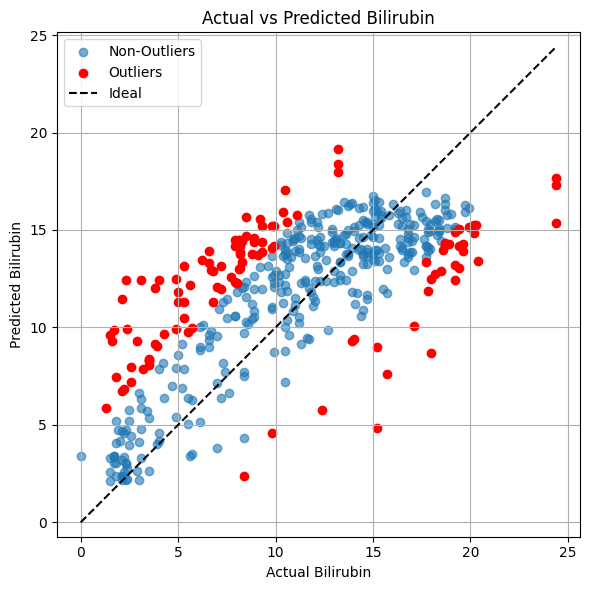

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure NumPy arrays for safe indexing
y_true = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

# Identify outliers based on top 5% absolute error
absolute_error = np.abs(y_true - y_pred)
threshold = np.percentile(absolute_error, 75)
is_outlier = absolute_error > threshold

# Scatter plot: Actual vs Predicted with outliers in red
plt.figure(figsize=(6, 6))
plt.scatter(y_true[~is_outlier], y_pred[~is_outlier], label="Non-Outliers", alpha=0.6)
plt.scatter(y_true[is_outlier], y_pred[is_outlier], color="red", label="Outliers")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label="Ideal")
plt.xlabel("Actual Bilirubin")
plt.ylabel("Predicted Bilirubin")
plt.title("Actual vs Predicted Bilirubin")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.metrics import mean_absolute_error, r2_score

# Filter non-outliers
y_true_filtered = y_true[~is_outlier]
y_pred_filtered = y_pred[~is_outlier]

# Compute new metrics
filtered_mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
filtered_r2 = r2_score(y_true_filtered, y_pred_filtered)

print(f"Filtered MAE (non-outliers): {filtered_mae:.3f}")
print(f"Filtered R² (non-outliers): {filtered_r2:.3f}")


Filtered MAE (non-outliers): 1.980
Filtered R² (non-outliers): 0.779


In [59]:
# Get predictions for the full dataset
all_preds = model.predict(processed_rgb)
residuals = np.abs(processed_labels - all_preds.flatten())

# Determine top 5% threshold
threshold = np.percentile(residuals, 75)

# Keep only non-outliers
non_outlier_indices = np.where(residuals <= threshold)[0]

# Filter data
rgb_filtered = processed_rgb[non_outlier_indices]
labels_filtered = processed_labels[non_outlier_indices]

print("Filtered data shape:", rgb_filtered.shape)


70/70 [==============================] - 7s 104ms/step
Filtered data shape: (1677, 128, 128, 3)


In [60]:
from sklearn.model_selection import train_test_split

rgb_train, rgb_test, y_train, y_test = train_test_split(
    rgb_filtered, labels_filtered, test_size=0.2, random_state=42)


In [62]:
# Build the model again (reuse your `build_rgb_hsv_concat_model`)
input_shape = rgb_train.shape[1:]

history = model.fit(
    rgb_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
34/34 [==============================] - 14s 409ms/step - loss: 8.8146 - mae: 2.3407 - val_loss: 6.5768 - val_mae: 2.1062 - lr: 2.5000e-04
Epoch 2/150
34/34 [==============================] - 11s 330ms/step - loss: 8.8265 - mae: 2.3435 - val_loss: 5.5079 - val_mae: 1.9655 - lr: 2.5000e-04
Epoch 3/150
34/34 [==============================] - 11s 338ms/step - loss: 8.9467 - mae: 2.3514 - val_loss: 8.9572 - val_mae: 2.3636 - lr: 2.5000e-04
Epoch 4/150
34/34 [==============================] - 12s 353ms/step - loss: 9.4960 - mae: 2.4057 - val_loss: 6.3041 - val_mae: 2.0536 - lr: 2.5000e-04
Epoch 5/150
34/34 [==============================] - 14s 404ms/step - loss: 9.1847 - mae: 2.3580 - val_loss: 6.4840 - val_mae: 2.0746 - lr: 2.5000e-04
Epoch 6/150
34/34 [==============================] - 14s 412ms/step - loss: 8.8948 - mae: 2.3196 - val_loss: 5.7678 - val_mae: 1.9883 - lr: 2.5000e-04
Epoch 7/150
34/34 [==============================] - 15s 441ms/step - loss: 8.2738 - mae: 2.25

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(rgb_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

11/11 [==============================] - 1s 90ms/step

Test Results:
RMSE: 2.09
MAE: 1.73
R²: 0.81
